In [ ]:
import gensim.downloader as api
model = api.load('word2vec-google-news-300')

In [2]:
words = ['truck', 'vegetable', 'village', 'dance', 'human']

for word in words:
    similar_words = model.most_similar(word, topn=5)
    print(f"Words similar to '{word}':")
    for similar_word in similar_words:
        print(f"  {similar_word[0]}: {similar_word[1]:.4f}")
    print()

Words similar to 'truck':
  pickup_truck: 0.7817
  trucks: 0.7529
  dump_truck: 0.7441
  tractor_trailer: 0.7256
  van: 0.7253

Words similar to 'vegetable':
  vegetables: 0.7448
  Vegetable: 0.6996
  veggie: 0.6505
  tomato: 0.6411
  potato: 0.6292

Words similar to 'village':
  town: 0.7326
  hamlet: 0.7308
  villages: 0.7204
  Village: 0.6267
  villagers: 0.5965

Words similar to 'dance':
  dancing: 0.8381
  dances: 0.8213
  dancers: 0.7514
  Dance: 0.7395
  ballroom_dance: 0.7040

Words similar to 'human':
  human_beings: 0.6140
  humans: 0.5918
  impertinent_flamboyant_endearingly: 0.5868
  employee_Laura_Althouse: 0.5639
  humankind: 0.5636



In [3]:
analogies = [
    ('king', 'man', 'woman', 'queen'),
    ('Paris', 'France', 'Germany', 'Berlin'),
    ('walking', 'walk', 'run', 'running')
]

for a, b, c, expected in analogies:
    predicted = model.most_similar(positive=[a, c], negative=[b], topn=1)[0][0]
    print(f"{a} - {b} + {c} ~= {predicted} (expected: {expected})")

king - man + woman ~= queen (expected: queen)
Paris - France + Germany ~= Berlin (expected: Berlin)
walking - walk + run ~= running (expected: running)


In [4]:
import numpy as np
import pandas as pd

In [5]:
data=pd.read_csv(r"C:\Users\ASUS\Desktop\College\Sem VII\NLP\SNLP-main\SNLP-main\IMDB Dataset.csv\IMDB Dataset.csv")

In [6]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
data_info = data.info()
data_head = data.head()
data_sentiment_distribution = data['sentiment'].value_counts()
data_info, data_head, data_sentiment_distribution

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


(None,
                                               review sentiment
 0  One of the other reviewers has mentioned that ...  positive
 1  A wonderful little production. <br /><br />The...  positive
 2  I thought this was a wonderful way to spend ti...  positive
 3  Basically there's a family where a little boy ...  negative
 4  Petter Mattei's "Love in the Time of Money" is...  positive,
 sentiment
 positive    25000
 negative    25000
 Name: count, dtype: int64)

In [8]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

def clean_review(review):
    words = word_tokenize(review.lower())
    filtered_words = [word for word in words if word not in stop_words and word not in punctuations]
    return ' '.join(filtered_words)

data['cleaned_review'] = data['review'].apply(clean_review)

cleaned_reviews_sample = data['cleaned_review'].head()
cleaned_reviews_sample

0    one reviewers mentioned watching 1 oz episode ...
1    wonderful little production br br filming tech...
2    thought wonderful way spend time hot summer we...
3    basically 's family little boy jake thinks 's ...
4    petter mattei 's `` love time money '' visuall...
Name: cleaned_review, dtype: object

In [9]:
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def get_average_vector(review, model):
    words = review.split()
    feature_vector = np.zeros(model.vector_size, dtype='float32')
    num_words = 0
    for word in words:
        if word in model.wv:
            feature_vector = np.add(feature_vector, model.wv[word])
            num_words += 1
    if num_words > 0:
        feature_vector = np.divide(feature_vector, num_words)
    return feature_vector

F1-score: 87.72%


c:\Users\ronit\OneDrive\Desktop\College\Python\New folder\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


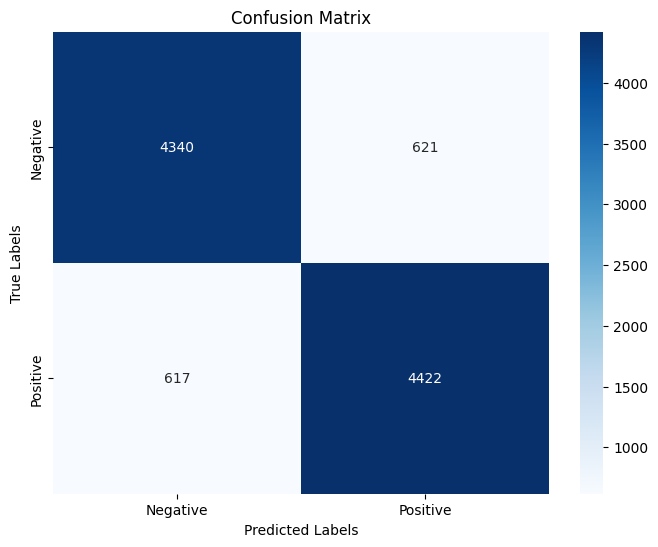

In [10]:
# skip gram model
tokenized_reviews = [review.split() for review in data['cleaned_review']]
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, sg=1, workers=4)

X = np.array([get_average_vector(review, word2vec_model) for review in data['cleaned_review']])
y = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f'F1-score: {f1 * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

F1-score: 85.92%


c:\Users\ronit\OneDrive\Desktop\College\Python\New folder\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


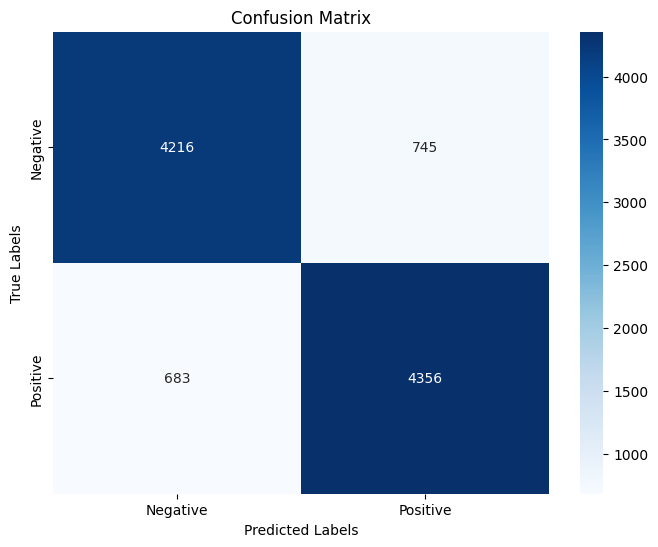

In [11]:
# CBOW model
tokenized_reviews = [review.split() for review in data['cleaned_review']]
word2vec_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, sg=0, workers=4)

X = np.array([get_average_vector(review, word2vec_model) for review in data['cleaned_review']])
y = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f'F1-score: {f1 * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

F1-score: 85.21%


c:\Users\ronit\OneDrive\Desktop\College\Python\New folder\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


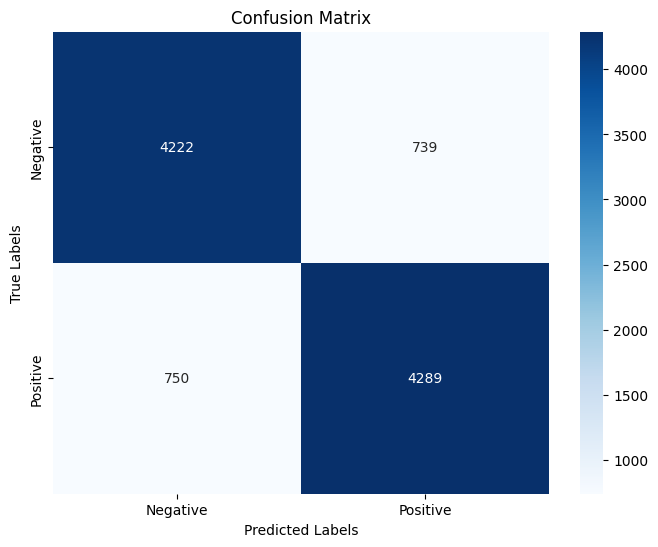

In [12]:
# Pre trained model
model = api.load('word2vec-google-news-300')

def get_pretrained_average_vector(review, model):
    words = review.split()
    feature_vector = np.zeros(model.vector_size, dtype='float32')
    num_words = 0
    for word in words:
        if word in model:
            feature_vector = np.add(feature_vector, model[word])
            num_words += 1
    if num_words > 0:
        feature_vector = np.divide(feature_vector, num_words)
    return feature_vector

X = np.array([get_pretrained_average_vector(review, model) for review in data['cleaned_review']])
y = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f'F1-score: {f1 * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()